# K Nearest Neighbors and SVM

This notebook will examine KNN and SVM classification for the Heart dataset.

## Loading and Preparing the Data

First let's load the data into a `pandas` dataframe (similar to the R dataframe) and format the categorical variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read in data
heart_df = pd.read_csv('heart.csv')
print(heart_df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  


In [2]:
# convert columns to categorical
# df[name] similar to the df$name notation
for col_name in ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']:
    heart_df[col_name] = heart_df[col_name].astype('category')

# split into target vector and feature matrix (split X and Y)
heart_feats = heart_df.drop(columns=['target'])
heart_target = np.array(heart_df['target'])

# convert category variables to dummy variable encoding (similar to the model.matrix())
# can use drop_first=True in get_dummies to get rid of redundant first encoding
heart_feats = pd.get_dummies(heart_feats, drop_first=True)
print(heart_feats.head())

# split into training and test set
from sklearn.model_selection import train_test_split
feat_train, feat_test, resp_train, resp_test = train_test_split(heart_feats, heart_target, test_size=0.25)

   age  trestbps  chol  thalach  oldpeak  sex_1  cp_1  cp_2  cp_3  fbs_1  ...  \
0   63       145   233      150      2.3      1     0     0     1      1  ...   
1   37       130   250      187      3.5      1     0     1     0      0  ...   
2   41       130   204      172      1.4      0     1     0     0      0  ...   
3   56       120   236      178      0.8      1     1     0     0      0  ...   
4   57       120   354      163      0.6      0     0     0     0      0  ...   

   exang_1  slope_1  slope_2  ca_1  ca_2  ca_3  ca_4  thal_1  thal_2  thal_3  
0        0        0        0     0     0     0     0       1       0       0  
1        0        0        0     0     0     0     0       0       1       0  
2        0        0        1     0     0     0     0       0       1       0  
3        0        0        1     0     0     0     0       0       1       0  
4        1        0        1     0     0     0     0       0       1       0  

[5 rows x 22 columns]


In [3]:
# scale columns (important for both KNN and SVM)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# get mean and standard deviation for each column according to train data
scaler.fit(feat_train)
# scale columns of train and test data
feat_train = scaler.transform(feat_train)
feat_test = scaler.transform(feat_test)

## Basic KNN classifier

We will do a KNN classifier with a fixed number of 5 neighbors first.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(feat_train, resp_train)

resp_pred = knn_clf.predict(feat_test)
print('Accuracy:', np.sum(resp_pred == resp_test)/len(resp_pred))

Accuracy: 0.8289473684210527


## Cross Validation for KNN

Now we will do cross-validation to choose the optimal value of `k`.

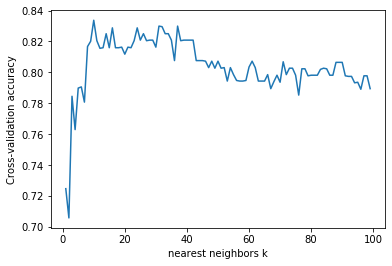

Best k: 10


In [5]:
# empty containers for CV errors
cv_errors = []

# set up code for 5-fold cv
from sklearn.model_selection import KFold
n_folds = 20
max_neighbors = 100

# loop over number of neighbors k
for k in range(1, max_neighbors):
    # 10-fold cross validation for each k
    kf = KFold(n_splits=n_folds)
    # container for errors for each fold
    fold_errors = np.zeros(n_folds)
    
    # loop over folds
    for fold_num, (cv_train, cv_test) in enumerate(kf.split(feat_train)):
        # split into cv train and test set
        cv_feat_train = feat_train[cv_train]
        cv_resp_train = resp_train[cv_train]
        cv_feat_test = feat_train[cv_test]
        cv_resp_test = resp_train[cv_test]
        
        # make cv model
        cv_knn_clf = KNeighborsClassifier(n_neighbors=k)
        cv_knn_clf.fit(cv_feat_train, cv_resp_train)
        
        # get cv accuracy for this fold
        cv_resp_pred = cv_knn_clf.predict(cv_feat_test)
        fold_errors[fold_num] = np.sum(cv_resp_pred == cv_resp_test) / len(cv_resp_pred)
        
    cv_errors += [np.mean(fold_errors)]
    
plt.plot(np.arange(1, max_neighbors), cv_errors)
plt.xlabel('nearest neighbors k')
plt.ylabel('Cross-validation accuracy')
plt.show()
        
best_k = np.argmax(np.array(cv_errors)) + 1
print('Best k:', best_k)

In [6]:
knn_clf_best_k = KNeighborsClassifier(n_neighbors=best_k)
knn_clf_best_k.fit(feat_train, resp_train)

resp_pred_best_k = knn_clf_best_k.predict(feat_test)
print('Accuracy:', np.sum(resp_pred_best_k == resp_test)/len(resp_pred))

Accuracy: 0.8552631578947368


## Support Vector Machines

We will now look at how to use support vector machines.

In [7]:
from sklearn import svm

# Linear SVM (C is the cost parameter for violating constraints, can tune with cross-val)
# tuning C with cross-validation will probably give better results!
svm_lin = svm.SVC(C=1.0).fit(feat_train, resp_train)

# get the value of the linear predictor beta_0 + beta_1 X_1 + ... + beta_p X_p
# standard prediction uses the threshold 0 (corresponding to the decision boundary)
# in general, can use other thresholds, just like for logistic regression/LDA/QDA/etc.
scores_svm_lin = svm_lin.decision_function(feat_test)
print(scores_svm_lin)

[ 0.38354949  1.67484054 -0.30221501  0.17521599  1.32784987  1.67500214
  0.59508688 -1.4018909   0.27697464  0.86507159 -0.50231987 -0.92014991
  0.00415428  1.81823132  0.15955015  1.13126252 -1.29387505  0.1552881
  1.30335565  1.58169152 -0.6808243   0.86411919  0.77159084  1.41569747
 -0.10289258  0.28264631  1.12148469  1.36580239  1.46060334 -1.73319549
 -0.98584805 -0.48710625 -0.21192223 -2.01989307  1.01488797  0.72849412
  1.64513793 -0.62933314  1.35518524 -0.79246022  1.16736901 -1.63983821
 -1.68719561  0.33790598 -0.48216544 -1.15299616  0.93028029 -0.83799002
  1.3236209   0.77159084  1.4532957   0.51402754  1.04135872 -0.7897613
 -0.67777606 -1.02157818  0.61357461 -1.71821581  0.09312178 -1.09979892
 -0.72504007  0.80183744 -1.78071609  0.48198967 -1.59820179 -1.97300035
  1.22753781  1.42372137  1.3993472   0.63778889  1.19426479  1.67670326
  1.2491237  -0.6148521   0.3090015   0.27442605]


In [8]:
# now let's make non-linear SVMs

# svm with polynomial kernel
# degree is the degree of the polynomial
# coef0 gives the value of the constant added to the polynomial kernel (usually use 1)
# tune degree by cross-validation for better results
svm_poly = svm.SVC(C=1.0, kernel='poly', degree=3, coef0=1).fit(feat_train, resp_train)
scores_svm_poly = svm_poly.decision_function(feat_test)

# svm with gaussian kernel
# degree is the degree of the polynomial
# gamma gives size of radius for gaussian kernel (tune with cross-val)
svm_gauss = svm.SVC(C=1.0, kernel='rbf', gamma=0.01).fit(feat_train, resp_train)
scores_svm_gauss = svm_gauss.decision_function(feat_test)

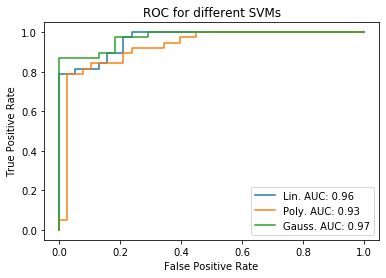

In [9]:
# make roc curve
from sklearn.metrics import roc_curve, auc

# metrics for linear svm
fpr_lin, tpr_lin, _ = roc_curve(resp_test, scores_svm_lin)
auc_lin = auc(fpr_lin, tpr_lin)

# metrics for polynomial svm
fpr_poly, tpr_poly, _ = roc_curve(resp_test, scores_svm_poly)
auc_poly = auc(fpr_poly, tpr_poly)

# metrics for gaussian svm
fpr_gauss, tpr_gauss, _ = roc_curve(resp_test, scores_svm_gauss)
auc_gauss = auc(fpr_gauss, tpr_gauss)

# plot the info
plt.plot(fpr_lin, tpr_lin, label='Lin. AUC: {0:0.2f}'.format(auc_lin))
plt.plot(fpr_poly, tpr_poly, label='Poly. AUC: {0:0.2f}'.format(auc_poly))
plt.plot(fpr_gauss, tpr_gauss, label='Gauss. AUC: {0:0.2f}'.format(auc_gauss))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for different SVMs')
plt.legend(loc='lower right')

In [10]:
print("{}: type({})\n{}: type({})".format(fpr_gauss, type(fpr_gauss),tpr_gauss, type(fpr_gauss)))

[0.         0.         0.         0.         0.         0.13157895
 0.13157895 0.18421053 0.18421053 0.28947368 0.28947368 1.        ]: type(<class 'numpy.ndarray'>)
[0.         0.02631579 0.60526316 0.65789474 0.86842105 0.86842105
 0.89473684 0.89473684 0.97368421 0.97368421 1.         1.        ]: type(<class 'numpy.ndarray'>)


In [11]:
print("{}: type({})\n{}: type({})".format(resp_test, type(resp_test),scores_svm_lin, type(scores_svm_lin)))

[1 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1
 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 0
 1 0]: type(<class 'numpy.ndarray'>)
[ 0.38354949  1.67484054 -0.30221501  0.17521599  1.32784987  1.67500214
  0.59508688 -1.4018909   0.27697464  0.86507159 -0.50231987 -0.92014991
  0.00415428  1.81823132  0.15955015  1.13126252 -1.29387505  0.1552881
  1.30335565  1.58169152 -0.6808243   0.86411919  0.77159084  1.41569747
 -0.10289258  0.28264631  1.12148469  1.36580239  1.46060334 -1.73319549
 -0.98584805 -0.48710625 -0.21192223 -2.01989307  1.01488797  0.72849412
  1.64513793 -0.62933314  1.35518524 -0.79246022  1.16736901 -1.63983821
 -1.68719561  0.33790598 -0.48216544 -1.15299616  0.93028029 -0.83799002
  1.3236209   0.77159084  1.4532957   0.51402754  1.04135872 -0.7897613
 -0.67777606 -1.02157818  0.61357461 -1.71821581  0.09312178 -1.09979892
 -0.72504007  0.80183744 -1.78071609  0.48198967 -1.59820179 -1.97300035
  1.22753781